Platforms detected: PostGIS, TimescaleDB, SedonaDB, SpaceTime, MobilityDB, MobilityDB_Time_Partitioned, MobilityDB_Space_Partitioned
Remaining entries after warm-up filtering: 2100


/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_71091/2178745523.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["occurrence_rank"] = df.groupby(["platform", "query_type"]).cumcount() + 1
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_71091/2178745523.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_71091/2178745523.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in

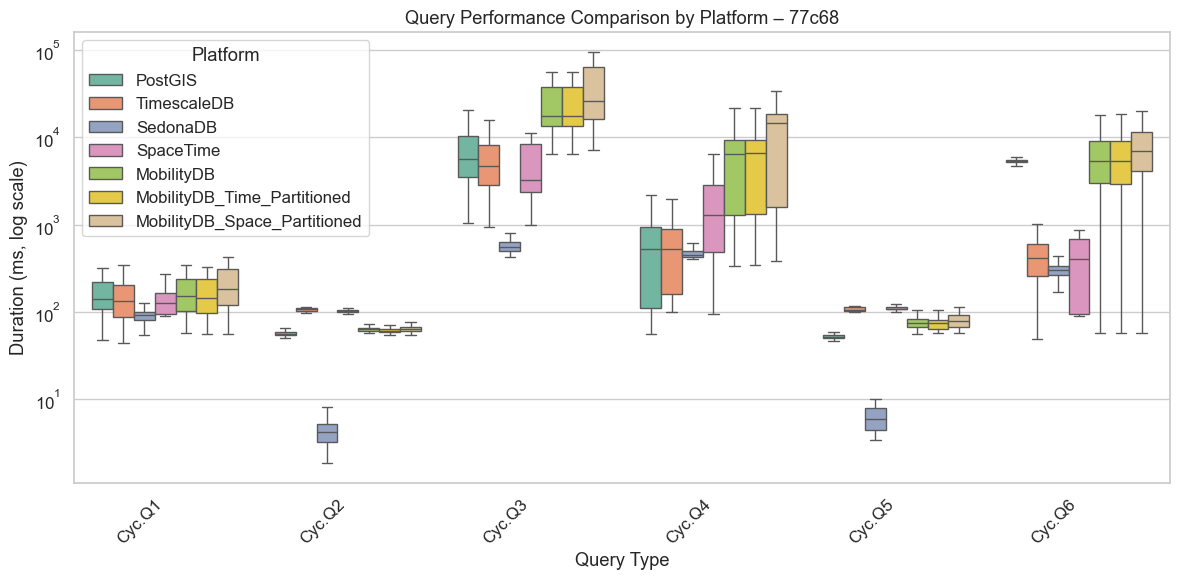

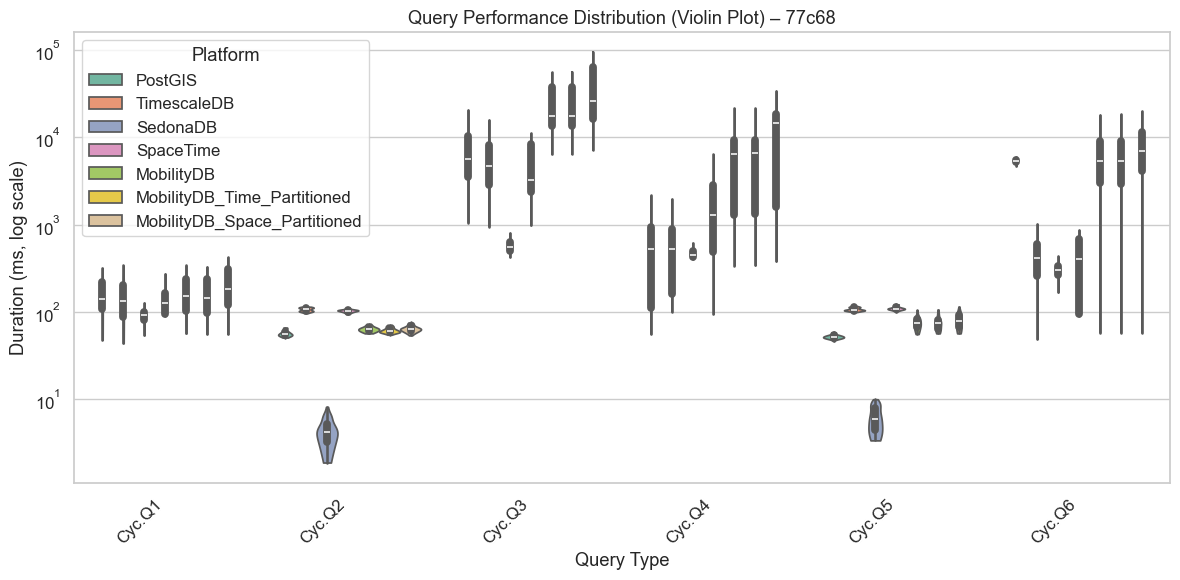

✅ Boxplot and violin plot created.


Generating ECDF plots per query...


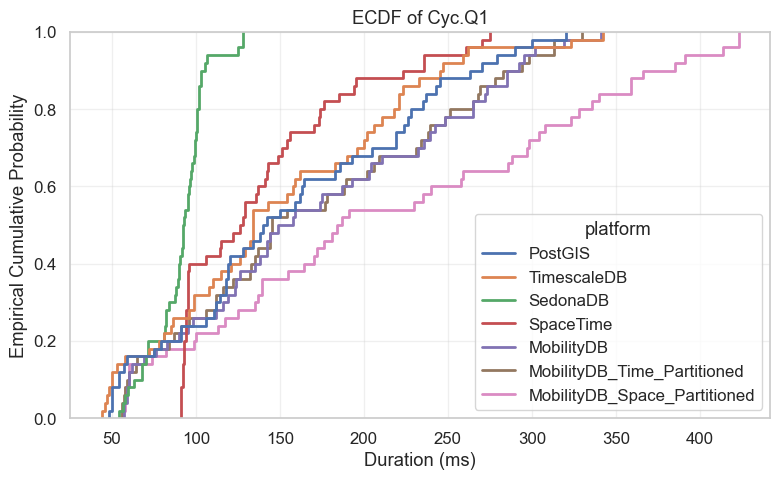

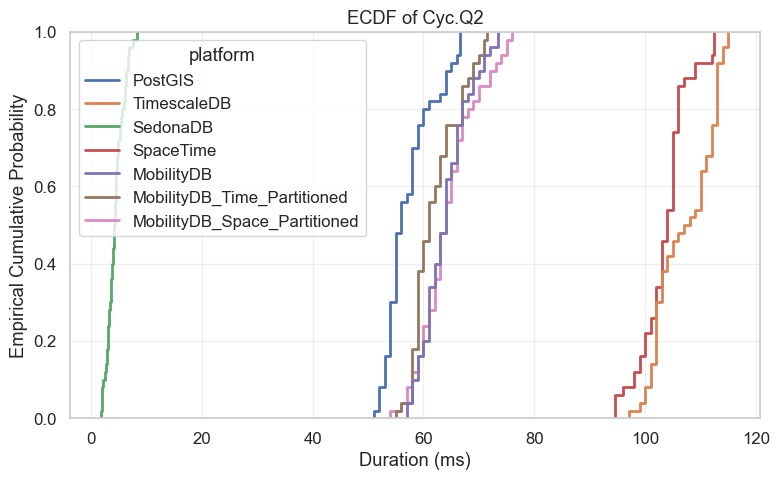

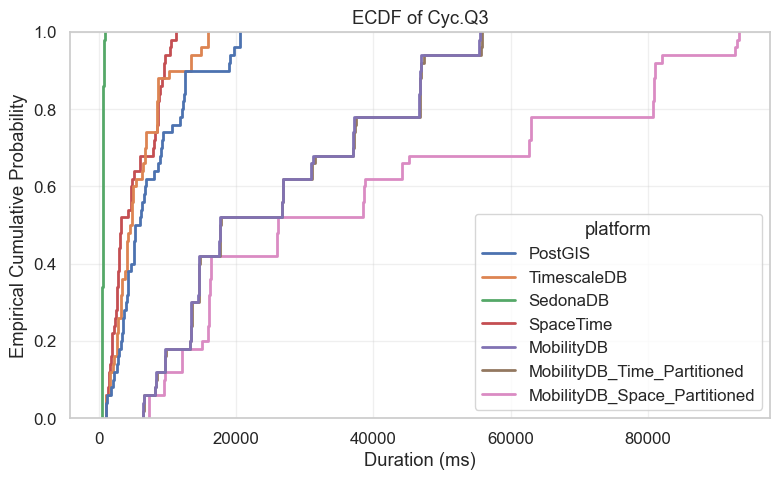

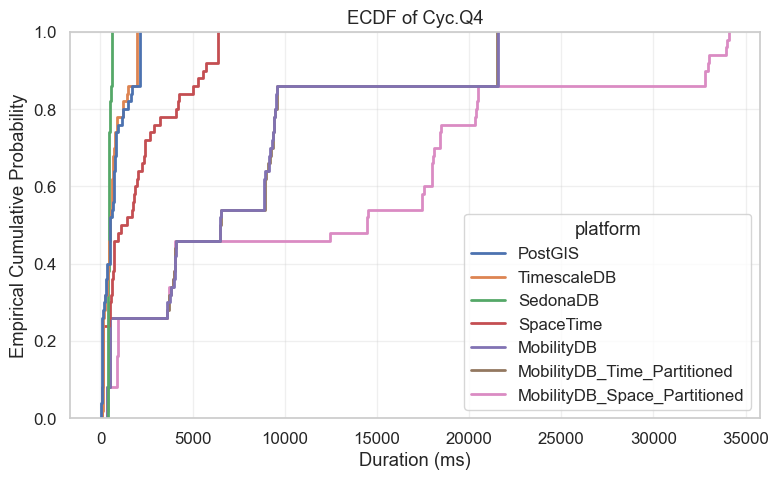

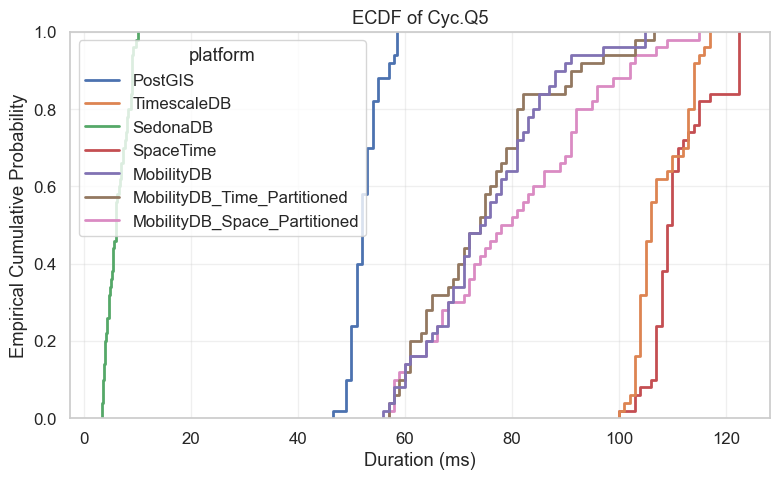

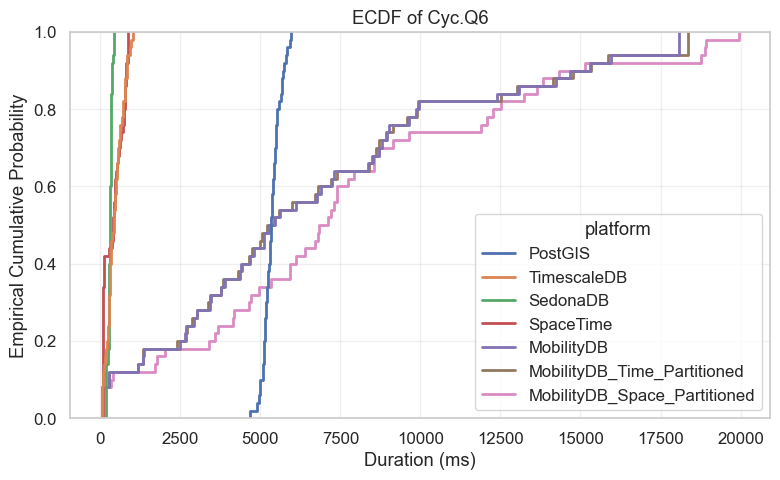

Performance summary (median duration in ms):


/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_71091/2178745523.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["platform", "query_type"])["duration_ms"]


platform,PostGIS,TimescaleDB,SedonaDB,SpaceTime,MobilityDB,MobilityDB_Time_Partitioned,MobilityDB_Space_Partitioned
query_type,,,,,,,
Cyc.Q1,141.000000,134.000000,92.701954,127.000000,153.500000,145.000000,185.500000
Cyc.Q2,56.000000,107.500000,4.200205,104.000000,64.000000,61.000000,64.000000
Cyc.Q3,5628.000000,4671.500000,550.257354,3248.500000,17631.000000,17694.500000,26084.000000
Cyc.Q4,526.000000,521.000000,447.940524,1281.500000,6487.000000,6526.500000,14449.500000
Cyc.Q5,52.000000,106.000000,5.980290,109.500000,74.500000,74.000000,79.000000
Cyc.Q6,5339.500000,416.000000,305.729988,405.000000,5362.500000,5318.000000,6972.000000



📊 Queries where TimescaleDB was faster than PostGIS:
  • Cyc.Q1     — faster by 7.0 ms
  • Cyc.Q3     — faster by 956.5 ms
  • Cyc.Q4     — faster by 5.0 ms
  • Cyc.Q6     — faster by 4923.5 ms

📊 Queries where SedonaDB was faster than PostGIS:
  • Cyc.Q1     — faster by 48.3 ms
  • Cyc.Q2     — faster by 51.8 ms
  • Cyc.Q3     — faster by 5077.7 ms
  • Cyc.Q4     — faster by 78.1 ms
  • Cyc.Q5     — faster by 46.0 ms
  • Cyc.Q6     — faster by 5033.8 ms

📊 Queries where SpaceTime was faster than PostGIS:
  • Cyc.Q1     — faster by 14.0 ms
  • Cyc.Q3     — faster by 2379.5 ms
  • Cyc.Q6     — faster by 4934.5 ms

📊 Queries where MobilityDB was faster than PostGIS:
  None.

📊 Queries where MobilityDB_Time_Partitioned was faster than PostGIS:
  • Cyc.Q6     — faster by 21.5 ms

📊 Queries where MobilityDB_Space_Partitioned was faster than PostGIS:
  None.

📊 Queries where SedonaDB was faster than TimescaleDB:
  • Cyc.Q1     — faster by 41.3 ms
  • Cyc.Q2     — faster by 103.3 ms
  • Cyc.

In [12]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations

# Mapping of original query names → renamed display names
# QUERY_RENAME_MAP = {
#     "countActiveCrossingsInPeriod": "AIS.Q1",
#     "CrossingsActiveAtGivenHourOfDay": "AIS.Q2",
#     "countActiveCrossingsNearIsland": "AIS.Q3",
#     "crossingsConnectTwoGivenHarbours": "AIS.Q4",
#     "averageDurationCrossingStartAtHarbourInPeriod": "AIS.Q5",
#     "HarbourActivityInPeriod": "AIS.Q6",
# }

# # Enforced x-axis order
# QUERY_ORDER = ["AIS.Q1", "AIS.Q2", "AIS.Q3", "AIS.Q4", "AIS.Q5", "AIS.Q6"]

QUERY_RENAME_MAP = {
    "SortRidesByHourInPeriod": "Cyc.Q1",
    "averageRideDurationDuringDay": "Cyc.Q2",
    "countActiveRideInDistrict": "Cyc.Q3",
    "RidesPastOrToUniversity": "Cyc.Q4",
    "averageRideDurationToGoAtUniversityInPeriod": "Cyc.Q5",
    "rideCrossSeveralDistrictsInPeriod": "Cyc.Q6",
}

QUERY_ORDER = ["Cyc.Q1", "Cyc.Q2", "Cyc.Q3", "Cyc.Q4", "Cyc.Q5", "Cyc.Q6"]

# QUERY_RENAME_MAP = {
#     "FlightUpdatesInPeriod": "Avi.Q1",
#     "airportUtilizationInPeriod": "Avi.Q2",
#     "countFlightsInCounties": "Avi.Q3",
#     "flightClosestToPoint": "Avi.Q4",
#     "flightsInCountyInPeriod": "Avi.Q5",
#     "inCityRadiusInPeriod": "Avi.Q6",
# }

# QUERY_ORDER = ["Avi.Q1", "Avi.Q2", "Avi.Q3", "Avi.Q4", "Avi.Q5", "Avi.Q6"]
# Enforced platform order
PLATFORM_ORDER = [
    "PostGIS",
    "TimescaleDB",
    "SedonaDB",
    "SpaceTime",
    "MobilityDB",
    "MobilityDB_Time_Partitioned",
    "MobilityDB_Space_Partitioned",
]


def analyze_queries(file_ending: str):
    log_dir = Path("../logs")
    log_pattern = re.compile(
        r"\[.*?\]\s+\[(?P<platform>[\w_]+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
    )
    log_pattern_alt = re.compile(
        r"\[?(?P<platform>[\w_]+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
    )

    log_files = list(log_dir.glob(f"*{file_ending}.log"))
    if not log_files:
        print(f"No log files found in {log_dir} ending with '{file_ending}'.")
        return

    all_data = []
    for log_file in log_files:
        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                match = log_pattern.search(line)
                if match:
                    all_data.append({
                        "platform": match.group("platform"),
                        "query_type": match.group("query"),
                        "duration_ms": int(match.group("duration")),
                    })
                else:
                    match_alt = log_pattern_alt.search(line)
                    if match_alt:
                        all_data.append({
                            "platform": match_alt.group("platform"),
                            "query_type": match_alt.group("query_name"),
                            "duration_ms": float(match_alt.group("duration")),
                        })

    if not all_data:
        print("No valid log entries found.")
        return

    df = pd.DataFrame(all_data)

    # Apply query renaming
    df["query_type"] = df["query_type"].replace(QUERY_RENAME_MAP)

    # Convert to categorical with fixed ordering
    df["query_type"] = pd.Categorical(df["query_type"], categories=QUERY_ORDER, ordered=True)
    df["platform"] = pd.Categorical(df["platform"], categories=PLATFORM_ORDER, ordered=True)

    platforms_present = [p for p in PLATFORM_ORDER if p in df["platform"].unique()]
    print(f"Platforms detected: {', '.join(platforms_present)}")

    # Exclude first two occurrences (warm-up)
    df["occurrence_rank"] = df.groupby(["platform", "query_type"]).cumcount() + 1
    df = df[df["occurrence_rank"] > 2].copy()
    print(f"Remaining entries after warm-up filtering: {len(df)}")

    # Outlier clipping (IQR)
    def clip_outliers_iqr(data, column):
        def iqr_clip(group):
            q1 = group[column].quantile(0.25)
            q3 = group[column].quantile(0.75)
            iqr = q3 - q1
            lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            group[column] = group[column].clip(lower, upper)
            return group
        return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)

    df = clip_outliers_iqr(df, "duration_ms")

    # ------------ PLOTS (LOG SCALE) ------------
    sns.set(style="whitegrid", font_scale=1.1)

    # --- Boxplot ---
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=df, x="query_type", y="duration_ms", hue="platform", palette="Set2")
    ax.set_yscale("log")
    plt.title(f"Query Performance Comparison by Platform – {file_ending}")
    plt.xlabel("Query Type")
    plt.ylabel("Duration (ms, log scale)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Platform")
    plt.tight_layout()
    plt.savefig(f"query_boxplot_comparison_{file_ending}.pdf", dpi=300)
    plt.show()

    # --- Violin plot ---
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(data=df, x="query_type", y="duration_ms", hue="platform", palette="Set2", cut=0)
    ax.set_yscale("log")
    plt.title(f"Query Performance Distribution (Violin Plot) – {file_ending}")
    plt.xlabel("Query Type")
    plt.ylabel("Duration (ms, log scale)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Platform")
    plt.tight_layout()
    plt.savefig(f"query_violin_comparison_{file_ending}.pdf", dpi=300)
    plt.show()

    print("✅ Boxplot and violin plot created.\n")

    # --- ECDF Plots (per query) ---
    print("\nGenerating ECDF plots per query...")

    sns.set(style="whitegrid", font_scale=1.1)
    unique_queries = sorted(df["query_type"].unique())

    for query in unique_queries:
        subset = df[df["query_type"] == query]
        if subset.empty:
            continue

        subset = subset.copy()
        subset["platform"] = subset["platform"].cat.remove_unused_categories()

        plt.figure(figsize=(8, 5))
        ax = sns.ecdfplot(
            data=subset,
            x="duration_ms",
            hue="platform",
            linewidth=2,
        )
        #ax.set_xscale("log")

        plt.title(f"ECDF of {query}")
        plt.xlabel("Duration (ms)")
        plt.ylabel("Empirical Cumulative Probability")
        plt.grid(True, alpha=0.3)

        # # ---------- LEGEND RULES ----------
        # if query == "AIS.Q2":   # show legend ONLY for Q2
        #     handles, labels = ax.get_legend_handles_labels()
        #     if labels:
                
        # else:
        #     ax.get_legend().remove()  # ensure NO legend for other queries
        handles, labels = ax.get_legend_handles_labels()
        if labels:
            plt.legend(title="Platform")
            
        plt.tight_layout()
        plt.savefig(f"ecdf_{query}_{file_ending}.pdf", dpi=300)
        plt.show()


    # ------------ SUMMARY TABLE ------------
    summary = (
        df.groupby(["platform", "query_type"])["duration_ms"]
        .median()
        .reset_index()
        .pivot(index="query_type", columns="platform", values="duration_ms")
    )

    print("Performance summary (median duration in ms):")
    display(summary.style.background_gradient(cmap="RdYlGn_r"))

    # ------------ Pairwise comparisons ------------
    for plat_a, plat_b in combinations(platforms_present, 2):
        faster_mask = summary[plat_a] > summary[plat_b]
        faster_queries = summary[faster_mask].index.tolist()
        print(f"\n📊 Queries where {plat_b} was faster than {plat_a}:")
        if faster_queries:
            for q in faster_queries:
                diff = summary.loc[q, plat_a] - summary.loc[q, plat_b]
                print(f"  • {q:<10} — faster by {diff:.1f} ms")
        else:
            print("  None.")

    return df, summary


if __name__ == "__main__":
    df, summary = analyze_queries("77c68")


/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/1510094718.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["occurrence_rank"] = df.groupby(["platform", "query_type", "scale"]).cumcount() + 1
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/1510094718.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/1510094718.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, a

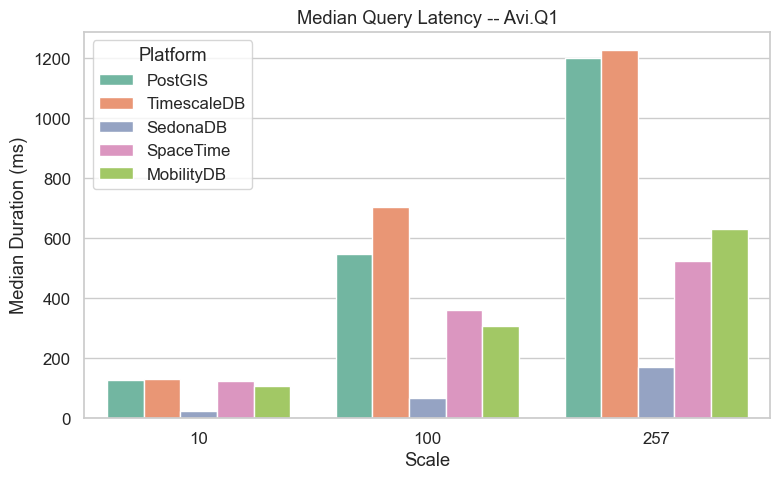

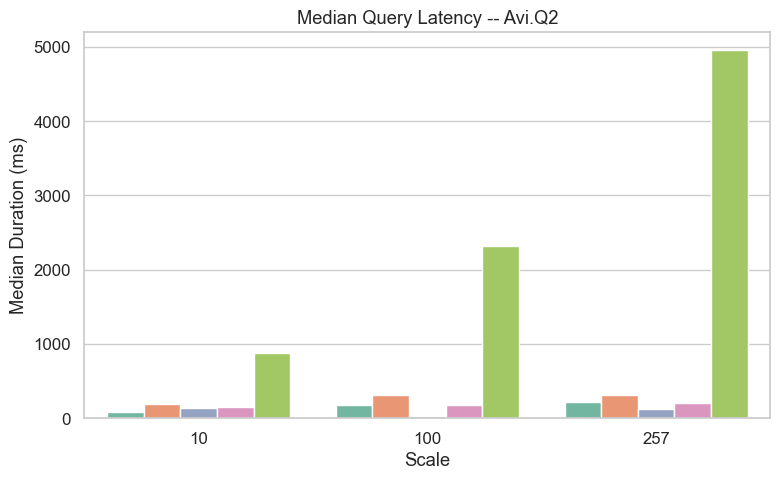

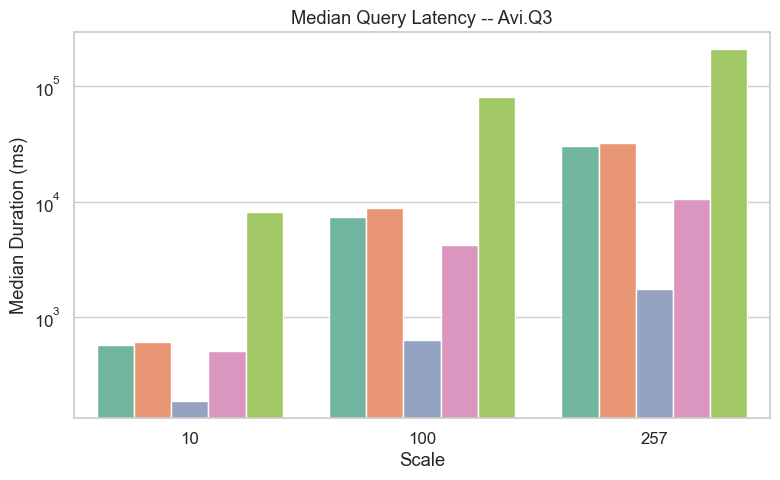

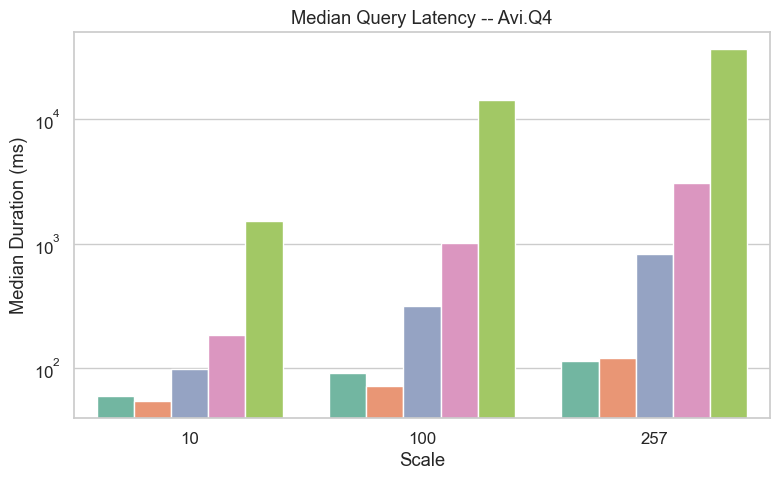

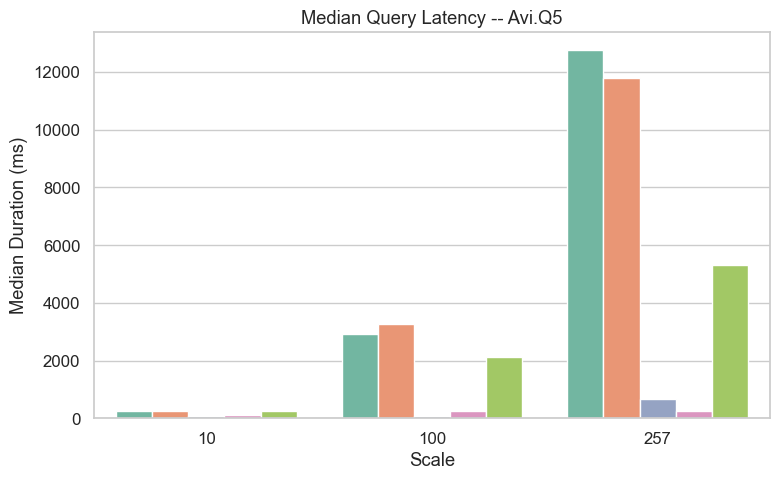

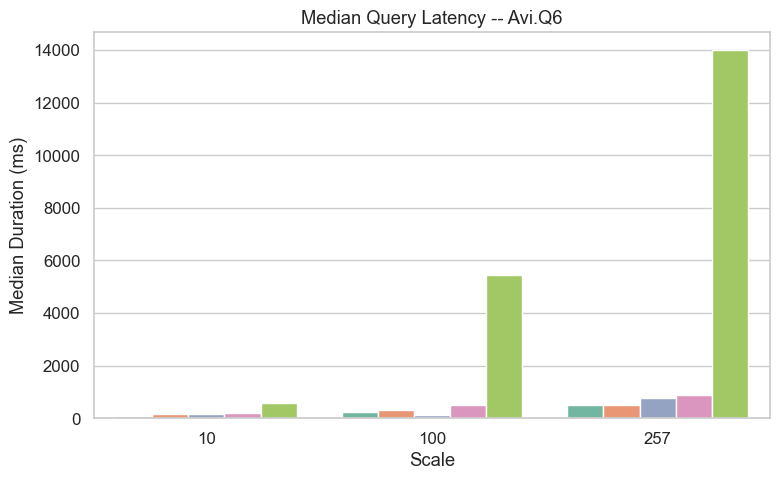

✅ Barplots per query created.


In [93]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- Query and platform mapping ---
QUERY_RENAME_MAP = {
    "FlightUpdatesInPeriod": "Avi.Q1",
    "airportUtilizationInPeriod": "Avi.Q2",
    "countFlightsInCounties": "Avi.Q3",
    "flightClosestToPoint": "Avi.Q4",
    "flightsInCountyInPeriod": "Avi.Q5",
    "inCityRadiusInPeriod": "Avi.Q6",
}

QUERY_ORDER = ["Avi.Q1", "Avi.Q2", "Avi.Q3", "Avi.Q4", "Avi.Q5", "Avi.Q6"]

PLATFORM_ORDER = [
    "PostGIS",
    "TimescaleDB",
    "SedonaDB",
    "SpaceTime",
    "MobilityDB",
]

SCALES = [10, 100, 257]
#SCALES = [100, 257]
# --- Regex patterns ---
log_pattern = re.compile(
    r"\[.*?\]\s+\[(?P<platform>[\w_]+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
)
log_pattern_alt = re.compile(
    r"\[?(?P<platform>[\w_]+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
)

# --- Functions ---
def parse_logs_for_identifier(identifier: str, scale: int, log_dir: Path) -> pd.DataFrame:
    """Find all logs for a given identifier and assign a scale."""
    files = sorted(log_dir.glob(f"*{identifier}*.log"))
    all_dfs = []

    for f in files:
        df = []
        with open(f, "r", encoding="utf-8") as file:
            for line in file:
                match = log_pattern.search(line)
                if match:
                    df.append({
                        "platform": match.group("platform"),
                        "query_type": match.group("query"),
                        "duration_ms": int(match.group("duration")),
                        "scale": scale
                    })
                else:
                    match_alt = log_pattern_alt.search(line)
                    if match_alt:
                        df.append({
                            "platform": match_alt.group("platform"),
                            "query_type": match_alt.group("query_name"),
                            "duration_ms": float(match_alt.group("duration")),
                            "scale": scale
                        })
        if df:
            all_dfs.append(pd.DataFrame(df))

    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()


def clip_outliers_iqr(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def iqr_clip(group):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        group[column] = group[column].clip(lower, upper)
        return group
    return df.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)


def analyze_queries(*identifiers):
    """Analyze multiple identifiers (one per scale) and create barplots."""
    log_dir = Path("../logs")
    all_dfs = []

    for scale, identifier in zip(SCALES, identifiers):
        df = parse_logs_for_identifier(identifier, scale, log_dir)
        if not df.empty:
            all_dfs.append(df)

    if not all_dfs:
        print("No valid log data found for the given identifiers.")
        return

    df = pd.concat(all_dfs, ignore_index=True)

    # Rename queries and enforce ordering
    df["query_type"] = df["query_type"].replace(QUERY_RENAME_MAP)
    df["query_type"] = pd.Categorical(df["query_type"], categories=QUERY_ORDER, ordered=True)
    df["platform"] = pd.Categorical(df["platform"], categories=PLATFORM_ORDER, ordered=True)

    # Remove warm-up entries
    df["occurrence_rank"] = df.groupby(["platform", "query_type", "scale"]).cumcount() + 1
    df = df[df["occurrence_rank"] > 2].copy()

    # Clip outliers
    df = clip_outliers_iqr(df, "duration_ms")

    # Compute median per platform, query, scale
    summary = df.groupby(["query_type", "scale", "platform"])["duration_ms"].median().reset_index()

    # --- Plot barplots per query ---
    sns.set(style="whitegrid", font_scale=1.1)
    for query in QUERY_ORDER:
        query_df = summary[summary["query_type"] == query]
        plt.figure(figsize=(8, 5))
        ax = sns.barplot(
            data=query_df,
            x="scale",
            y="duration_ms",
            hue="platform",
            order=SCALES,
            hue_order=PLATFORM_ORDER,
            palette="Set2",
        )
        

        #ax.set_yscale("log")
        plt.title(f"Median Query Latency -- {query}")
        plt.xlabel("Scale")
        plt.ylabel("Median Duration (ms)")
        if query == "Avi.Q1":
            plt.legend(title="Platform", loc="upper left")
        else:
            ax.get_legend().remove()
        if query == "Avi.Q3" or query == "Avi.Q4":
            plt.yscale("log")
        plt.tight_layout()
        plt.savefig(f"barplot_{query}_{'_'.join(identifiers)}.pdf", dpi=300)
        plt.show()

    print("✅ Barplots per query created.")
    return df, summary


if __name__ == "__main__":
    df, summary = analyze_queries("4084d","22222", "11111")


/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/3000210435.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/3000210435.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="platform", y="duration_ms", palette="Set2", ax=ax)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/3000210435.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is de

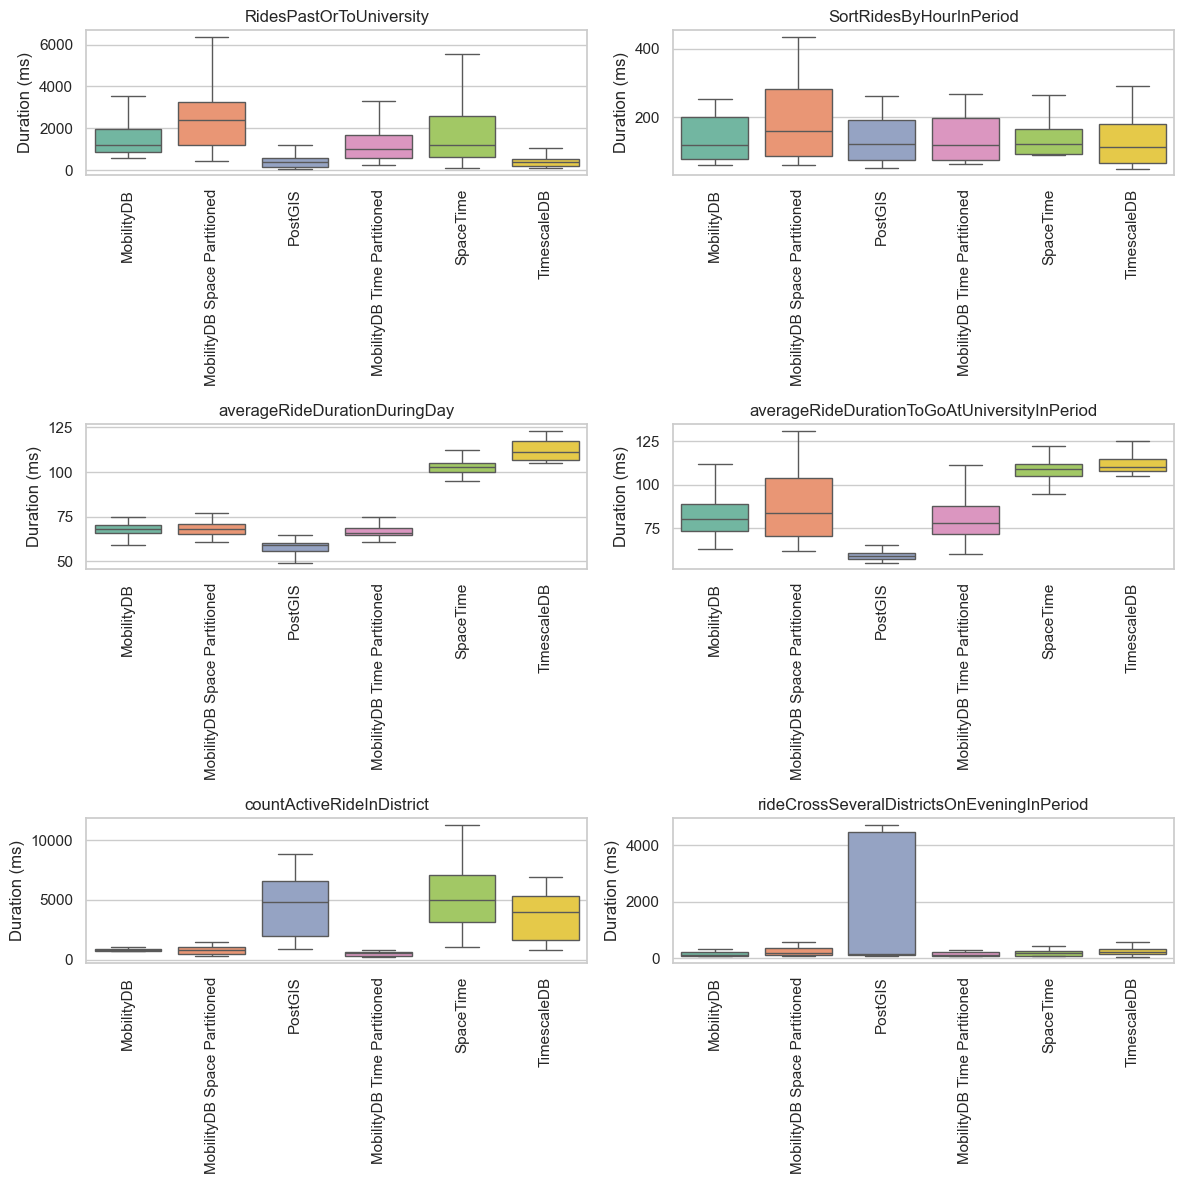

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


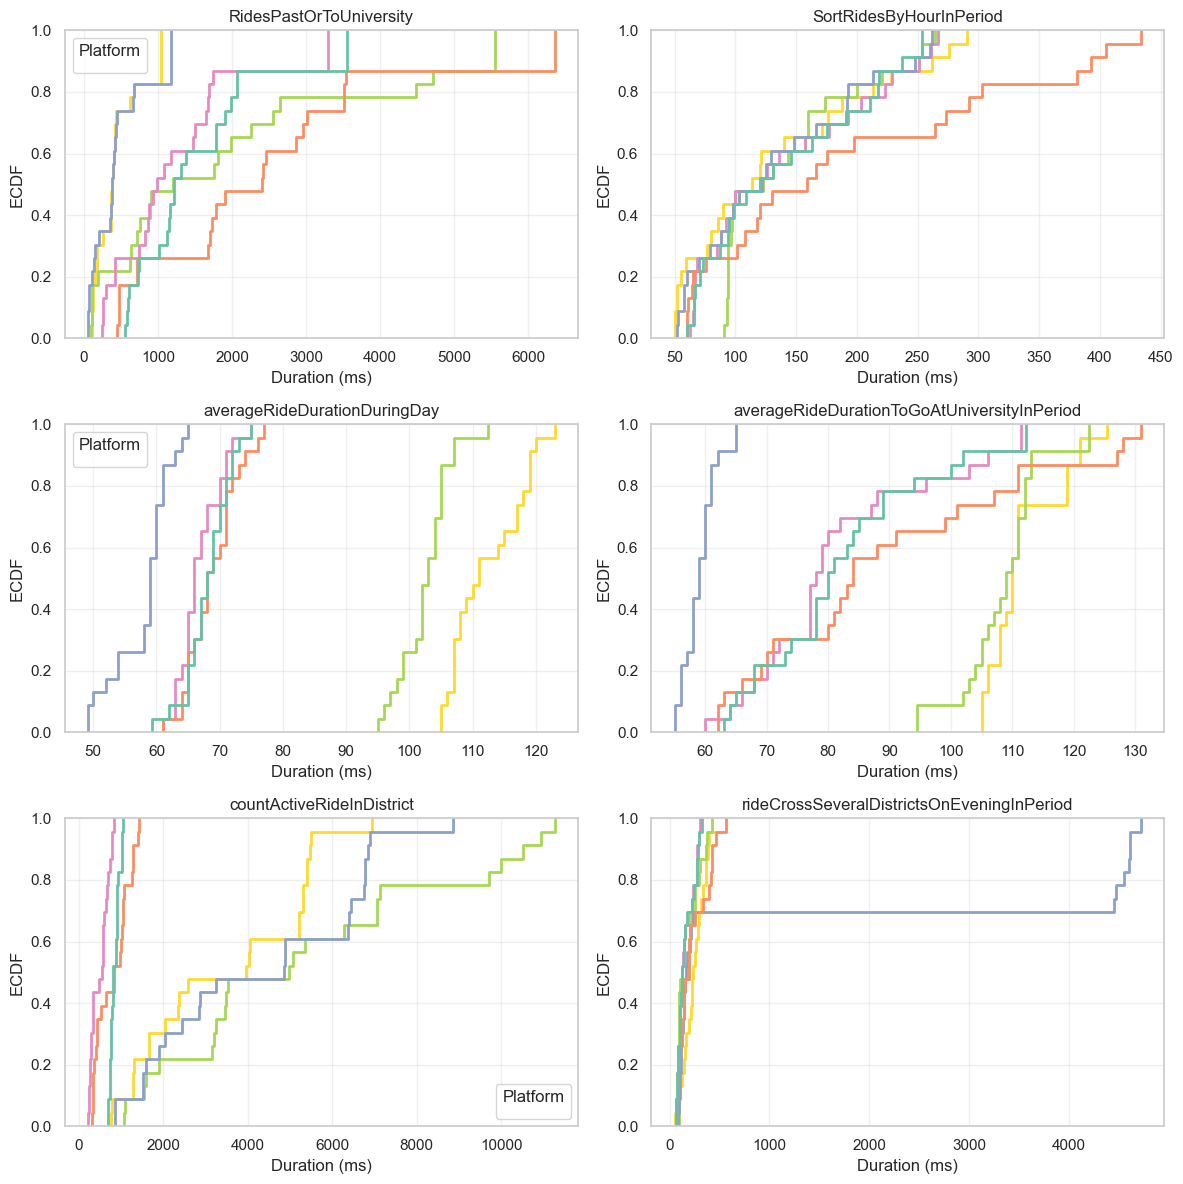

,platform,query_type,duration_ms,occurrence_rank
5,MobilityDB,countActiveRideInDistrict,906.0,3
7,MobilityDB,countActiveRideInDistrict,811.0,4
8,MobilityDB,RidesPastOrToUniversity,2069.0,3
15,MobilityDB,averageRideDurationDuringDay,68.0,3
16,MobilityDB,SortRidesByHourInPeriod,94.0,3
...,...,...,...,...
895,TimescaleDB,RidesPastOrToUniversity,108.0,25
896,TimescaleDB,rideCrossSeveralDistrictsOnEveningInPeriod,68.0,23
897,TimescaleDB,averageRideDurationDuringDay,110.0,25
898,TimescaleDB,rideCrossSeveralDistrictsOnEveningInPeriod,151.0,24


In [31]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations
import math

def analyze_queries_subplots(file_ending: str):
    """
    Analyze query performance and produce multi-panel subplots per query.
    Saves all plots as PDFs.

    Legend renaming:
        Space_Partitioned -> Space Partitioned
        DB_Partitioned    -> Time Partitioned
    """
    log_dir = Path("../logs")
    log_pattern = re.compile(
        r"\[.*?\]\s+\[(?P<platform>\w+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
    )
    log_pattern_alt = re.compile(
        r"\[?(?P<platform>\w+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
    )

    # Load logs
    log_files = list(log_dir.glob(f"*{file_ending}.log"))
    if not log_files:
        print(f"No log files found ending with '{file_ending}'")
        return

    all_data = []
    for log_file in log_files:
        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                m = log_pattern.search(line)
                if m:
                    all_data.append({
                        "platform": m.group("platform"),
                        "query_type": m.group("query"),
                        "duration_ms": int(m.group("duration"))
                    })
                else:
                    m2 = log_pattern_alt.search(line)
                    if m2:
                        all_data.append({
                            "platform": m2.group("platform"),
                            "query_type": m2.group("query_name"),
                            "duration_ms": float(m2.group("duration"))
                        })

    if not all_data:
        print("No valid log entries found.")
        return

    df = pd.DataFrame(all_data)

    # --- Rename platforms for legend ---
    def rename_platform(name):
        if "Space_Partitioned" in name:
            return "MobilityDB Space Partitioned"
        elif "DB_Partitioned" in name:
            return "MobilityDB Time Partitioned"
        else:
            return name
    df["platform"] = df["platform"].apply(rename_platform)

    platforms = sorted(df["platform"].unique())

    # Remove first 2 occurrences
    df["occurrence_rank"] = df.groupby(["platform", "query_type"]).cumcount() + 1
    df = df[df["occurrence_rank"] > 2].copy()

    # Clip outliers
    def clip_outliers_iqr(data, column):
        def iqr_clip(group):
            q1 = group[column].quantile(0.25)
            q3 = group[column].quantile(0.75)
            iqr = q3 - q1
            group[column] = group[column].clip(q1 - 1.5*iqr, q3 + 1.5*iqr)
            return group
        return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)

    df = clip_outliers_iqr(df, "duration_ms")

    # Unique queries
    queries = sorted(df["query_type"].unique())
    n_queries = len(queries)
    n_cols = 2
    n_rows = math.ceil(n_queries / n_cols)

    # --- Multi-panel Boxplots ---
    sns.set(style="whitegrid", font_scale=1.0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows), squeeze=False)

    for idx, query in enumerate(queries):
        ax = axes[idx//n_cols, idx%n_cols]
        subset = df[df["query_type"]==query]
        sns.boxplot(data=subset, x="platform", y="duration_ms", palette="Set2", ax=ax)
        ax.set_title(query)
        ax.set_xlabel("")
        ax.set_ylabel("Duration (ms)")
        ax.tick_params(axis='x', rotation=90)

    # Remove empty subplots
    for idx in range(n_queries, n_rows*n_cols):
        fig.delaxes(axes[idx//n_cols, idx%n_cols])

    plt.tight_layout()
    plt.savefig(f"query_boxplots_subplots_{file_ending}.pdf", dpi=300)
    plt.show()

    # --- Multi-panel ECDF plots ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows), squeeze=False)
    for idx, query in enumerate(queries):
        ax = axes[idx//n_cols, idx%n_cols]
        subset = df[df["query_type"]==query]
        sns.ecdfplot(data=subset, x="duration_ms", hue="platform", ax=ax, palette="Set2", linewidth=2)
        ax.set_title(query)
        ax.set_xlabel("Duration (ms)")
        ax.set_ylabel("ECDF")
        ax.grid(True, alpha=0.3)
        # Only show legend on first column or last row to reduce clutter
        if idx%n_cols == 0:
            ax.legend(title="Platform")
        else:
            ax.get_legend().remove()

    # Remove empty subplots
    for idx in range(n_queries, n_rows*n_cols):
        fig.delaxes(axes[idx//n_cols, idx%n_cols])

    plt.tight_layout()
    plt.savefig(f"query_ecdf_subplots_{file_ending}.pdf", dpi=300)
    plt.show()

    return df

analyze_queries_subplots("80b8e")
